In [3]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from solar_cell import all_series_bypass, SP_interconnection, TCT_interconnection
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [4]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=4096, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        self.fc3 = nn.Linear(mdim, mdim)
        outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        #outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        #print(x.shape)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        
        x = F.relu(x)
        #x = x.bool()
        
        return x

model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)
for param in model.parameters():
  print(param.dtype)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


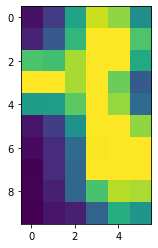

In [5]:
rand_smap = generate_gaussian(10, 10, 6)
plt.imshow(rand_smap)

In [6]:
rand_smap = torch.Tensor(np.expand_dims(rand_smap,0))
print(rand_smap)
print(rand_smap.shape)

tensor([[[ 0.5011,  1.7261,  5.8463,  9.1871,  8.3519,  4.9555],
         [ 0.9465,  2.7840,  6.6258, 10.0000, 10.0000,  7.2383],
         [ 7.1826,  6.9599,  8.6860, 10.0000, 10.0000,  6.0690],
         [10.0000, 10.0000,  8.6860, 10.0000,  7.7394,  2.8396],
         [ 5.5122,  5.6236,  7.4610, 10.0000,  8.4076,  3.5078],
         [ 0.5568,  1.8374,  5.1225, 10.0000, 10.0000,  8.3519],
         [ 0.2784,  1.2806,  3.5078,  9.9109, 10.0000, 10.0000],
         [ 0.0557,  1.2806,  3.2851, 10.0000, 10.0000, 10.0000],
         [ 0.1114,  0.8909,  3.2851,  7.1269,  8.9087,  8.7416],
         [ 0.0000,  0.5568,  0.8909,  3.1737,  6.2361,  5.2339]]])
torch.Size([1, 10, 6])


In [8]:
result = model(rand_smap)
print(result)
print(result.shape)

tensor([[0.0051, 0.0277, 0.0180,  ..., 0.0000, 0.0000, 0.0018]],
       grad_fn=<ReluBackward0>)
torch.Size([1, 10920])


In [1]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 16 # 32-64 is advisable
learning_rate = 1e-4 # sensitivity of gradient descent
num_epochs = 1 # iterations over entire dataset 

In [9]:
""" Generate 10x6 Shading Maps"""
filename = '10x6shading_maps.csv'
maps = []
for x in range(0, 100):
    rand_smap = generate_gaussian(10, 10, 6)
    maps.append(rand_smap)

maps = pd.Series(maps, name='Shading Maps')
maps.to_csv(filename)

In [10]:
""" Load Shading Maps"""
read_in = pd.read_csv('10x6shading_maps.csv')
    
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
data = [torch.Tensor(np.expand_dims(s,0)) for s in shading_series]
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
""" Create custom dataset """
class CustomDataset(Dataset):
    def __init__(self, df, rotate=None):
        self.df = df
        self.rotate = rotate # for rotation of shading maps?

    def __getitem__(self, index):
        #shading_map = self.df.iloc[index, 0]
        shading_map = shading_series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        
        return shading_map
        
    def __len__(self):
        return len(df)

dataset = CustomDataset(train_loader)
print(dataset.__getitem__(2))
print(dataset.__getitem__(2)[0].shape)
print(len(train_loader))

tensor([[[0.0000, 0.2724, 0.5609, 0.5369, 0.8013, 0.7612],
         [0.0000, 1.0000, 0.6170, 0.9455, 1.0000, 1.0000],
         [0.8654, 1.0000, 0.6971, 0.6490, 1.0000, 1.0000],
         [1.0000, 0.6330, 0.4647, 0.5849, 1.0000, 1.0000],
         [0.6090, 0.3365, 0.3365, 0.8494, 0.9135, 0.3526],
         [0.1923, 0.4888, 0.5769, 0.4006, 0.2564, 0.2885],
         [0.5689, 0.6811, 0.2003, 0.0881, 0.3686, 0.8253],
         [0.6250, 0.3686, 0.0801, 1.0000, 1.0000, 1.0000],
         [0.5769, 1.0000, 1.0000, 1.0000, 0.0881, 0.3365],
         [0.1282, 0.3926, 0.3846, 0.8013, 1.0000, 1.0000]]])
torch.Size([10, 6])
6


In [139]:
model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


In [21]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'model.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()

In [20]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [141]:
ratio_list = []
self_connections = []
conflicting_connections = []
loss_list = []

In [161]:
# iterate over epochs
#entropy_loss = nn.MSELoss(reduction='none')
entropy_loss = nn.MSELoss(reduction='none')
for epoch in range(num_epochs):
    
    # iterate over training dataset by batch
    for i, data in enumerate(train_loader, 0):

            shading_map = data
            shading_map = shading_map.to(device)
            result = model(shading_map)
            
            average_ratio = 0
            self_c = 0
            conflicting_c = 0
            
            filtered_embedding = np.empty((batch_size, 10920))
            for j in range(0, batch_size):
                embedding = result[j]
                embedding = np.squeeze(embedding.detach())
                embedding, terminal_array = embedding[:10800], embedding[10800:]
                embedding = embedding.reshape(10, 6, 10, 6, 3)
                terminal_array = terminal_array.reshape(10, 6, 2)
                
                series_connections = torch.count_nonzero(embedding[...,0]) + torch.count_nonzero(embedding[...,1])
                parallel_connections = torch.count_nonzero(embedding[...,2])
                if parallel_connections == 0:
                    average_ratio += 0
                elif parallel_connections > 0:
                    average_ratio += (series_connections / parallel_connections)
                
                moduleobj = SolarModule(10, 6)
                moduleobj.embedding = np.array(embedding.numpy(), dtype=bool)
                moduleobj.terminal_array = np.array(terminal_array.numpy(), dtype=bool)
                filtering = moduleobj.filter_embedding()
                self_c += filtering[0]
                conflicting_c += filtering[1]
                
                new_embedding = moduleobj.embedding
                new_terminal_array = moduleobj.terminal_array
                new_embedding = np.ndarray.flatten(new_embedding)
                new_terminal_array = np.ndarray.flatten(new_terminal_array)
                
                target = np.concatenate((new_embedding, new_terminal_array))
                
                filtered_embedding[j] = target
                
            target_tensor = torch.from_numpy(filtered_embedding).to(torch.float) # from_numpy may be double
            #target_tensor = torch.tensor(target_tensor, requires_grad=True)
            
            average_ratio /= batch_size
            self_c /= batch_size
            conflicting_c /= batch_size
            ratio_list.append(float(average_ratio))
            self_connections.append(self_c)
            conflicting_connections.append(conflicting_c)
            
            loss = entropy_loss(result, target_tensor)
            loss = torch.mean(loss,dtype=torch.float)
            print(loss.dtype, loss)
            #loss = loss.to(torch.long) # float types??
            #loss_list.append(float(loss))
            #loss = torch.mean(loss*(1-power))
            
            #loss = torch.tensor(conflicting_c, requires_grad=True)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(i, ratio_list[i], self_connections[i], conflicting_connections[i], loss)
    
# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding


torch.float32 tensor(0.2441, grad_fn=<MeanBackward0>)
0 1.9832720756530762 103.9375 1779.125 tensor(0.2441, grad_fn=<MeanBackward0>)
torch.float32 tensor(0.2427, grad_fn=<MeanBackward0>)
1 2.016669750213623 75.1875 1755.5 tensor(0.2427, grad_fn=<MeanBackward0>)
torch.float32 tensor(0.2426, grad_fn=<MeanBackward0>)
2 2.023925542831421 75.8125 1750.875 tensor(0.2426, grad_fn=<MeanBackward0>)
torch.float32 tensor(0.2438, grad_fn=<MeanBackward0>)
3 2.0272183418273926 75.90625 1750.75 tensor(0.2438, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

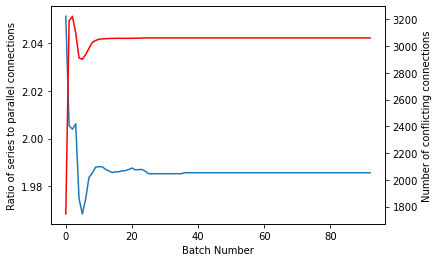

In [111]:
fig, ax1 = plt.subplots()
ax1.plot(ratio_list)
ax1.set_xlabel('Batch Number')
ax1.set_ylabel('Ratio of series to parallel connections')
#ax1.plot(self_connections)
ax2 = ax1.twinx()
ax2.plot(conflicting_connections, 'r')
ax2.set_ylabel('Number of conflicting connections')
#ax2.plot(loss_list, 'r')
plt.savefig('training_graph.png',dpi=300,bbox_inches="tight")

In [82]:
""" Load in evaluation series"""
read_in = pd.read_csv("evaluation_series.csv", header=0, names=['Shading Maps'], usecols=[1])
eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [91]:
class EvalDataset(Dataset):
    def __init__(self, series):
        self.series = series
    def __getitem__(self, index):
        shading_map = self.series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        return shading_map
    def __len__(self):
        return len(self.series)
evaldataset = EvalDataset(eval_series)
test_loader = torch.utils.data.DataLoader(evaldataset, batch_size=1)

In [112]:
embedding_list = []
terminal_list = []
power_list = []

In [113]:
''' evaluate model & visualise outputs'''
model.eval()
with torch.no_grad():
    # get single random image batch from test dataset
    for s in random.sample(list(test_loader), 100):
        
        # push images to gpu
        shading_map = s.to(device)
        # plot input image
        #plt.imshow(np.squeeze(shading_map))
        #plt.figure()
        # compute output image
        result = model(shading_map)
        #print(result)
        # get output image from gpu, reshape
        
        result = np.squeeze(result).cpu().numpy()
        embedding, terminal_array = result[:10800], result[10800:]        
        #print(embedding.shape)
        #print(terminal_array.shape)
        embedding = embedding.reshape(10, 6, 10, 6, 3)
        embedding = np.array(embedding, dtype=bool)
        
        embedding_list.append(np.copy(embedding)) # copy is required as filter_embedding() modifies both the embedding
                                                  # and the terminal array
        
        terminal_array = terminal_array.reshape(10, 6, 2)
        terminal_array = np.array(terminal_array, dtype=bool)
        
        terminal_list.append(np.copy(terminal_array))
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = embedding
        moduleobj.terminal_array = terminal_array
        moduleobj.shading_map = np.squeeze(shading_map).cpu().numpy()*10
        
        try:
            moduleobj.make_netlist()
        except ValueError:
            print(moduleobj.filter_embedding())
            moduleobj.make_netlist()
        
        try:
            moduleobj.simulate()
            power_list.append(round(moduleobj.MPP, 2))
            print("{} W, {} V, {} A".format(round(moduleobj.MPP, 2), round(moduleobj.VMP, 2), round(moduleobj.IMP, 2)))
        #moduleobj.plot_netlist(ymax=300)
        #moduleobj.imshow(3, 3)
        except:
            power_list.append(0)
            print("Simulation failed") 
        break

Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0002
(0, 3060, 3535, 18, 1, 0, 1.0)
264.51 W, 0.67 V, 394.78 A


In [97]:
embedding_list[0] == embedding_list[2]

array([[[[[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         ...,

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],

         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  T

In [81]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'Checkpoints/unsupervised-epochs1batchsize32.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [ ]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'Checkpoints/Batch42FromInit.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()